In [1]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


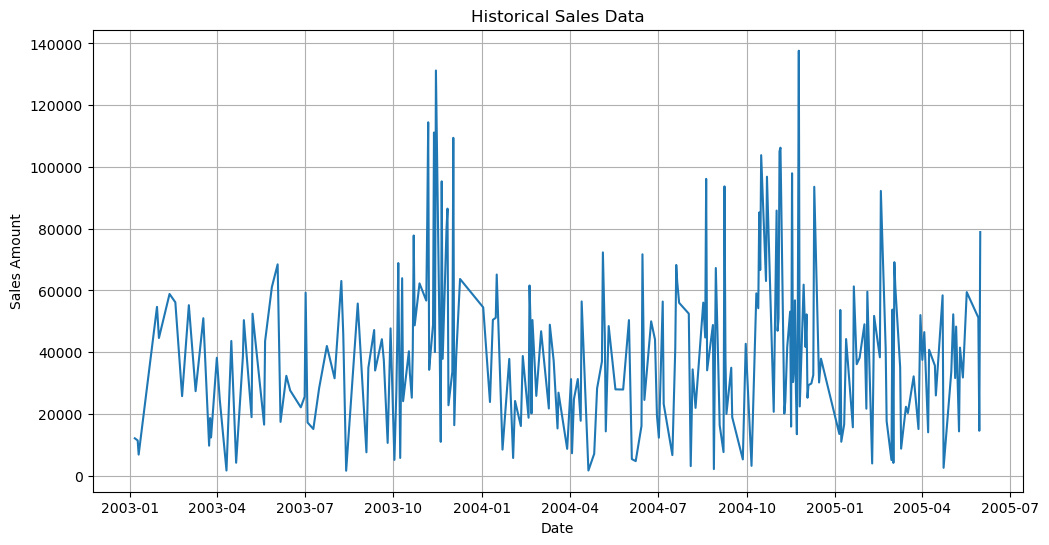

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Load the data
df = pd.read_csv('sales_data_sample.csv', encoding='iso-8859-1')

# Convert ORDERDATE to datetime and extract date components
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
df['year'] = df['ORDERDATE'].dt.year
df['month'] = df['ORDERDATE'].dt.month
df['day'] = df['ORDERDATE'].dt.day

# Aggregate sales by date
daily_sales = df.groupby('ORDERDATE')['SALES'].sum().reset_index()
daily_sales.columns = ['ds', 'y']

# Plot historical sales
plt.figure(figsize=(12, 6))
plt.plot(daily_sales['ds'], daily_sales['y'])
plt.title('Historical Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.grid(True)
plt.show()

In [10]:
# Split into train and test sets
train_size = int(len(daily_sales) * 0.8)
train = daily_sales[:train_size]
test = daily_sales[train_size:]

# Create and fit Prophet model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)
model.fit(train)

# Make future dataframe and predictions
future = model.make_future_dataframe(periods=len(test))
forecast = model.predict(future)

# Calculate metrics
y_true = test['y'].values
y_pred = forecast['yhat'][train_size:].values
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"Model Performance Metrics:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

13:03:26 - cmdstanpy - INFO - Chain [1] start processing
13:03:26 - cmdstanpy - INFO - Chain [1] done processing


Model Performance Metrics:
MAE: 17062.82
RMSE: 20998.91


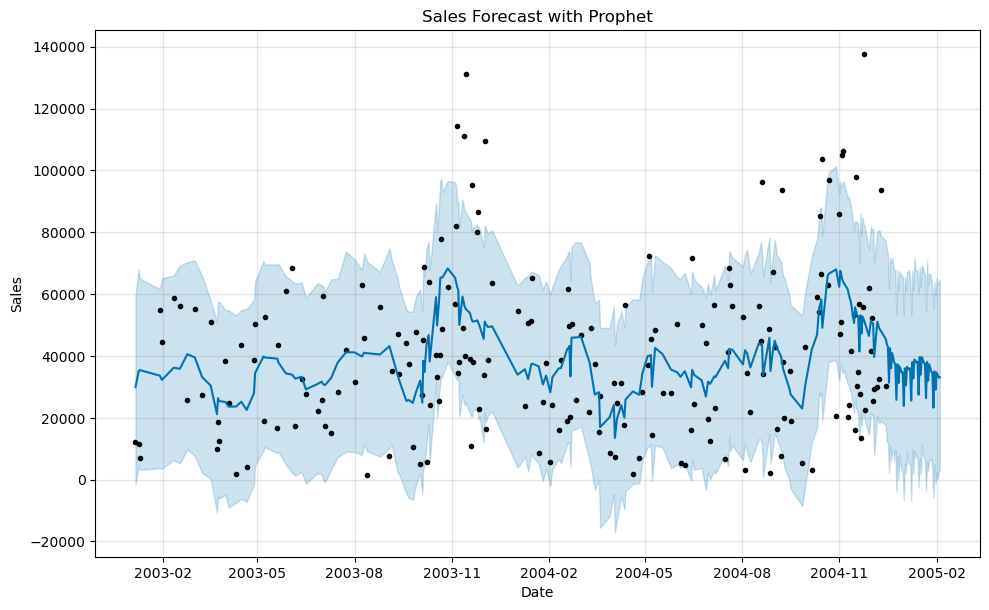

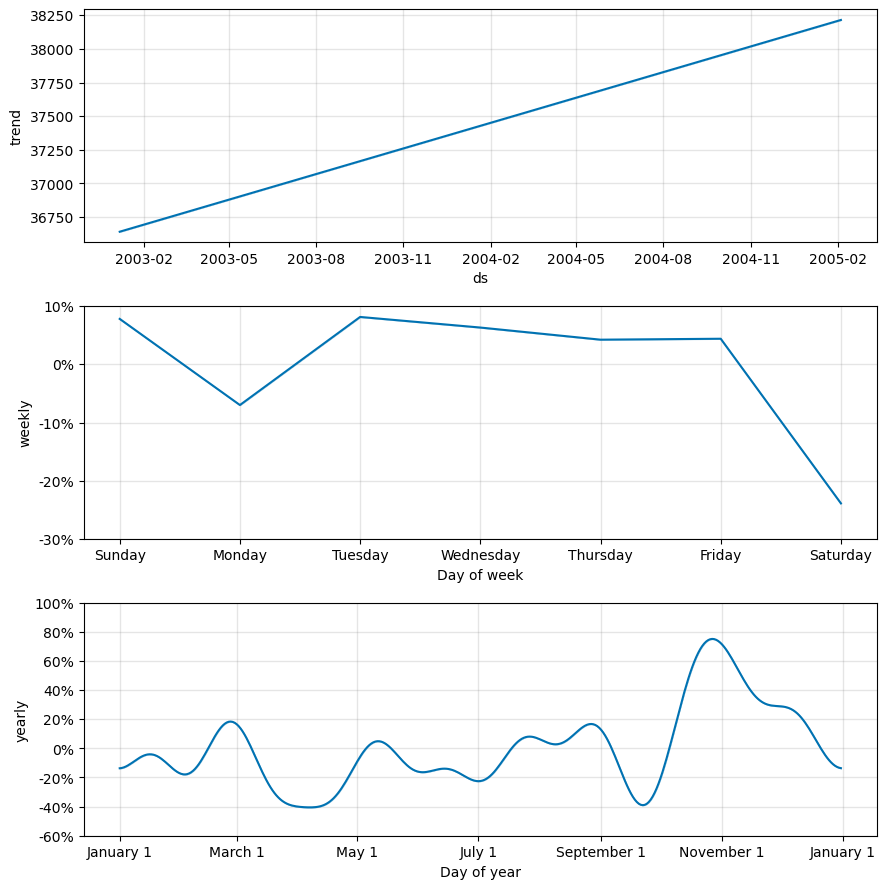

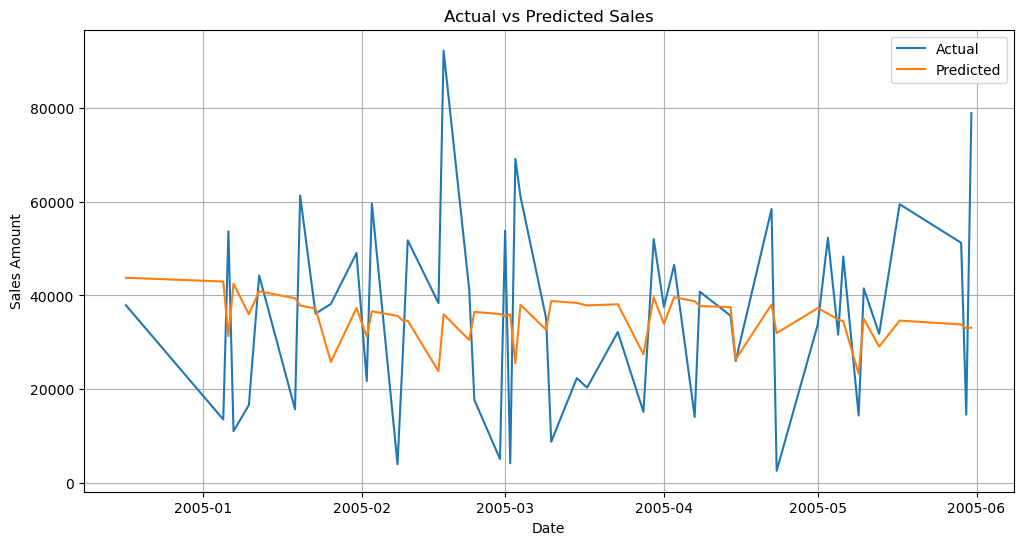

In [11]:
# Plot forecast components
fig1 = model.plot(forecast)
plt.title('Sales Forecast with Prophet')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Plot forecast components
fig2 = model.plot_components(forecast)
plt.show()

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], y_true, label='Actual')
plt.plot(test['ds'], y_pred, label='Predicted')
plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.show()

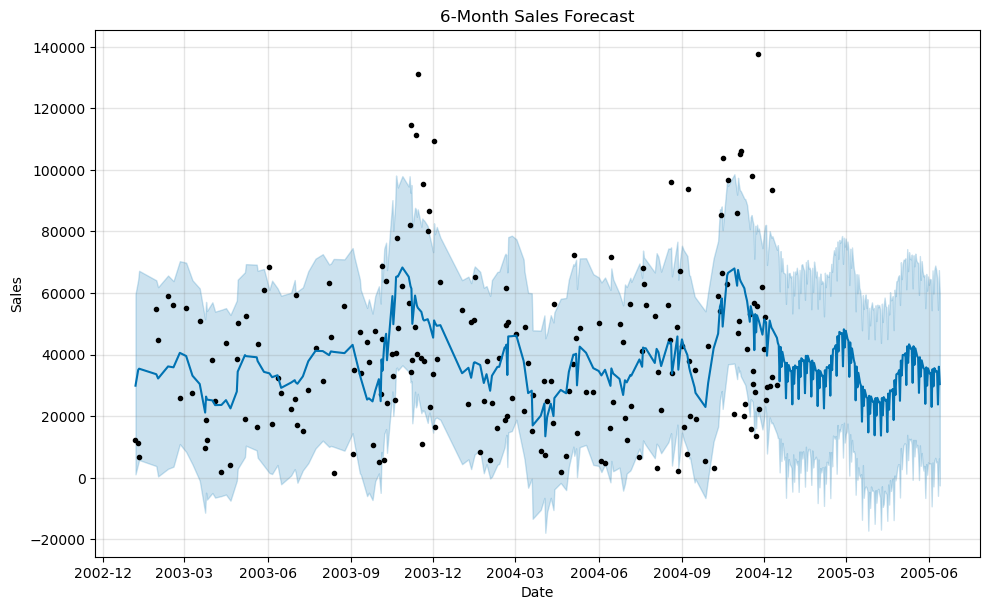

            ds          yhat    yhat_lower    yhat_upper
201 2004-12-16  43784.367701  12884.133934  75526.509901
202 2004-12-17  42970.412947  12843.726396  71643.351090
203 2004-12-18  31308.356768   1721.512924  60493.078612
204 2004-12-19  42494.808513  12733.858291  73596.623665
205 2004-12-20  35981.816651   5428.746411  67025.546819
..         ...           ...           ...           ...
376 2005-06-09  34361.143992   4975.031492  67524.734582
377 2005-06-10  34548.910998   5250.399973  64956.927858
378 2005-06-11  23781.577972  -5882.306379  54533.719027
379 2005-06-12  36055.346820   6249.833453  67435.667242
380 2005-06-13  30416.917600  -2498.337292  59846.085330

[180 rows x 4 columns]


In [12]:
# Create future dataframe for next 6 months
future = model.make_future_dataframe(periods=180)  # 6 months
forecast = model.predict(future)

# Plot the forecast
fig = model.plot(forecast)
plt.title('6-Month Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

# Show specific forecast values
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(180))

In [13]:
def calculate_accuracy_metrics(y_true, y_pred):
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Calculate Accuracy Percentage (100 - MAPE)
    accuracy = 100 - mape
    
    # Calculate symmetric Mean Absolute Percentage Error (sMAPE)
    smape = 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
    
    return mape, accuracy, smape

# Calculate metrics
mape, accuracy_percentage, smape = calculate_accuracy_metrics(y_true, y_pred)

print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Accuracy Percentage: {accuracy_percentage:.2f}%")
print(f"Symmetric MAPE (sMAPE): {smape:.2f}%")

Mean Absolute Percentage Error (MAPE): 118.61%
Accuracy Percentage: -18.61%
Symmetric MAPE (sMAPE): 53.24%


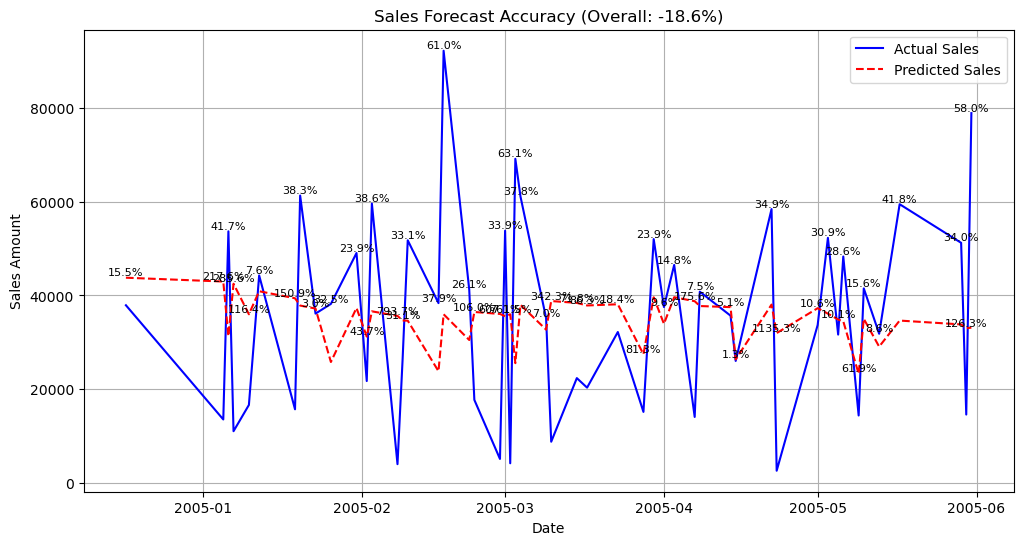

In [14]:
# Plot actual vs predicted with error percentage
plt.figure(figsize=(12, 6))
plt.plot(test['ds'], y_true, 'b-', label='Actual Sales')
plt.plot(test['ds'], y_pred, 'r--', label='Predicted Sales')

# Add error percentage text
for i, (actual, pred) in enumerate(zip(y_true, y_pred)):
    error_pct = abs(actual - pred)/actual * 100
    plt.text(test['ds'].iloc[i], max(actual, pred), 
             f'{error_pct:.1f}%', 
             ha='center', va='bottom', fontsize=8)

plt.title(f'Sales Forecast Accuracy (Overall: {accuracy_percentage:.1f}%)')
plt.xlabel('Date')
plt.ylabel('Sales Amount')
plt.legend()
plt.grid(True)
plt.show()